## Importing Required Libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Loading the Dataset

In [3]:
df = pd.read_csv("/content/Amazon_customer_review_dataset.csv")

In [8]:
print(df.head())

     customerID          Purchasedate  \
0        llyyue  2017-03-03T16:56:05Z   
1        Charmi  2017-03-03T16:56:05Z   
2  johnnyjojojo  2017-03-03T16:56:05Z   
3       Kdperry  2017-03-03T16:56:05Z   
4   Johnnyblack  2017-03-03T16:56:05Z   

                                                name   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   

                                          categories primaryCategories  \
0  Computers,Electronics Features,Tablets,Electro...       Electronics   
1  Computers,Electronics Features,Tablets,Electro...       Electronics   
2  Computers,Electronics Features,Tablets,Electro...       Electronics   
3  Computers,Electronics Features,Tablets,Electro...       Electronics  

# EDA

In [4]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 customerID            1
Purchasedate          0
name                  0
brand                 0
categories            0
primaryCategories     0
manufacturer          0
reviews.date          0
reviews.rating        0
reviews.text          0
reviews.title        13
dtype: int64


In [5]:
# Basic statistics
print("Data Description:\n", df.describe())

Data Description:
        reviews.rating
count     5000.000000
mean         4.596800
std          0.731804
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000


<ipython-input-6-693c3bc5549b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='reviews.rating', palette='viridis')


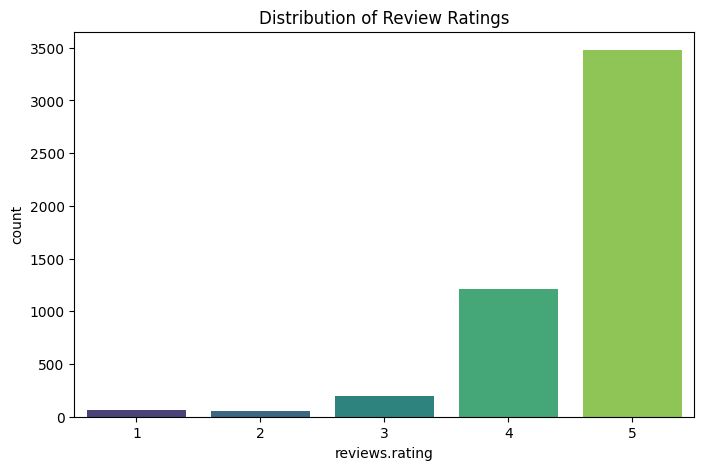

In [6]:
# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='reviews.rating', palette='viridis')
plt.title("Distribution of Review Ratings")
plt.show()

<ipython-input-9-db56ed66beb9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')


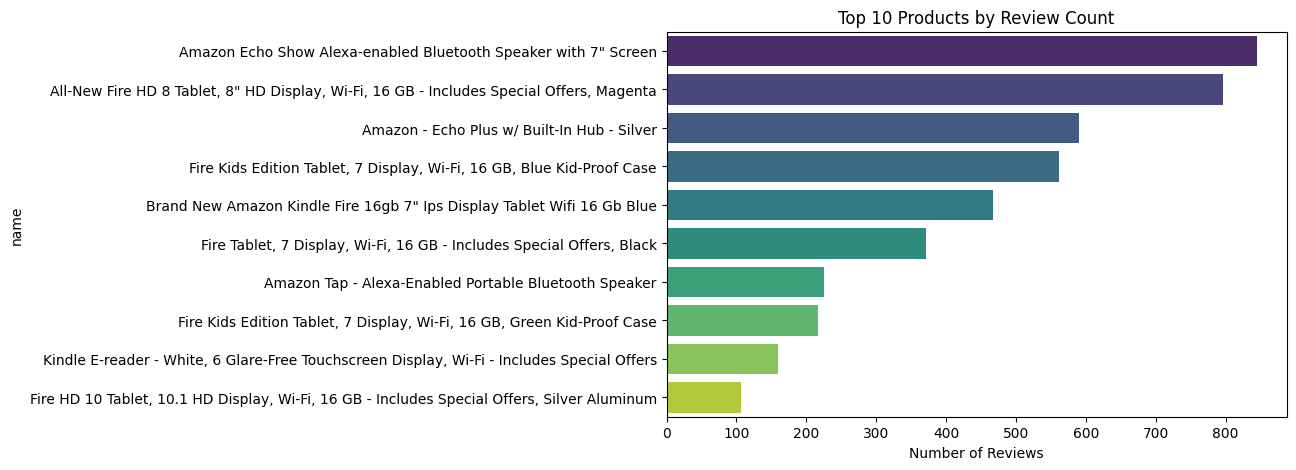

In [9]:
# Top products by review count
top_brands = df['name'].value_counts().head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')
plt.title("Top 10 Products by Review Count")
plt.xlabel("Number of Reviews")
plt.show()

In [10]:
# Handle missing values (optional)
df.fillna("", inplace=True)

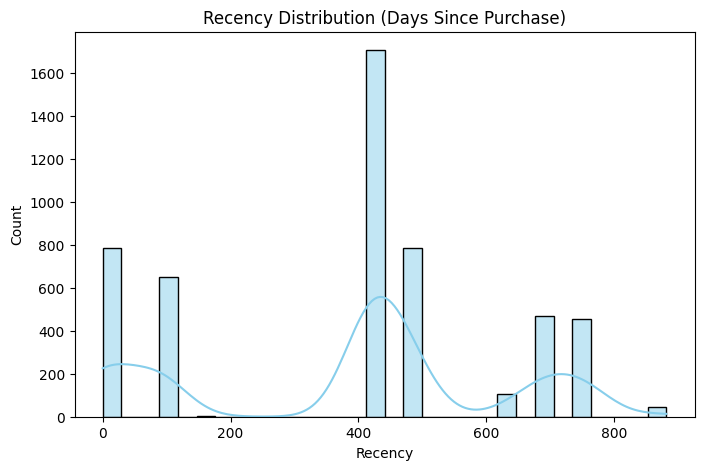

In [14]:
# Distribution of recency (purchase dates)
df['Purchasedate'] = pd.to_datetime(df['Purchasedate'])
df['Recency'] = (df['Purchasedate'].max() - df['Purchasedate']).dt.days
plt.figure(figsize=(8, 5))
sns.histplot(df['Recency'], bins=30, kde=True, color='skyblue')
plt.title("Recency Distribution (Days Since Purchase)")
plt.show()

# K-Means Algorithm

In [12]:
# Ensure 'Purchasedate' is in datetime format
df['Purchasedate'] = pd.to_datetime(df['Purchasedate'])

In [13]:
# Aggregating data for clustering
customer_behavior = df.groupby('customerID').agg({
    'reviews.rating': ['mean', 'count'],
    'Purchasedate': lambda x: (x.max() - x.min()).days  # Recency
}).reset_index()

In [15]:
# Flatten multi-level columns
customer_behavior.columns = ['customerID', 'avg_rating', 'review_count', 'recency']

In [16]:
# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_behavior[['avg_rating', 'review_count', 'recency']])

In [17]:
# Determine optimal clusters using Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

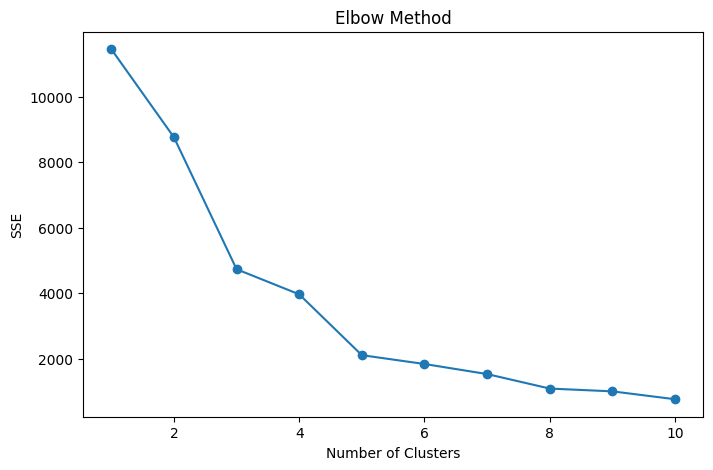

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

## The above graph shows that optimal number of Clusters is 8

In [19]:
# Apply K-Means with optimal clusters
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_behavior['cluster'] = kmeans.fit_predict(scaled_data)

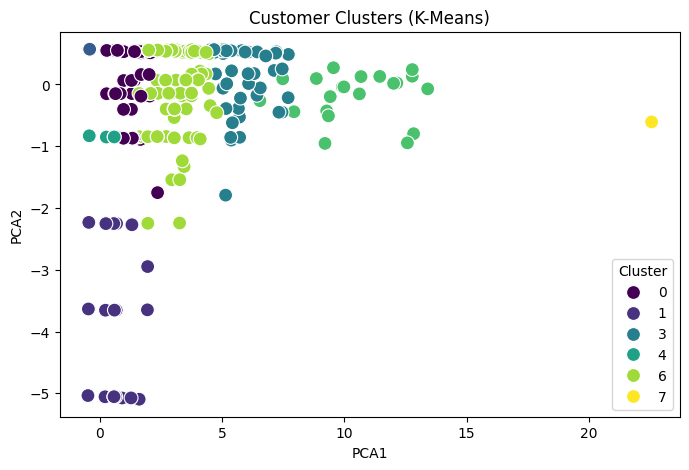

In [20]:
# Visualize clusters in 2D using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
customer_behavior['pca1'] = pca_data[:, 0]
customer_behavior['pca2'] = pca_data[:, 1]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=customer_behavior, x='pca1', y='pca2', hue='cluster', palette='viridis', s=100)
plt.title("Customer Clusters (K-Means)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

# Sentiment Analysis

In [21]:
from wordcloud import WordCloud

In [22]:
# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [26]:
def clean_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
        return ' '.join(tokens)
    return ""

df['cleaned_text'] = df['reviews.text'].apply(clean_text)

In [27]:
# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['cleaned_text'].apply(lambda text: sia.polarity_scores(text)['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')

<ipython-input-28-375ca8935687>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette='viridis')


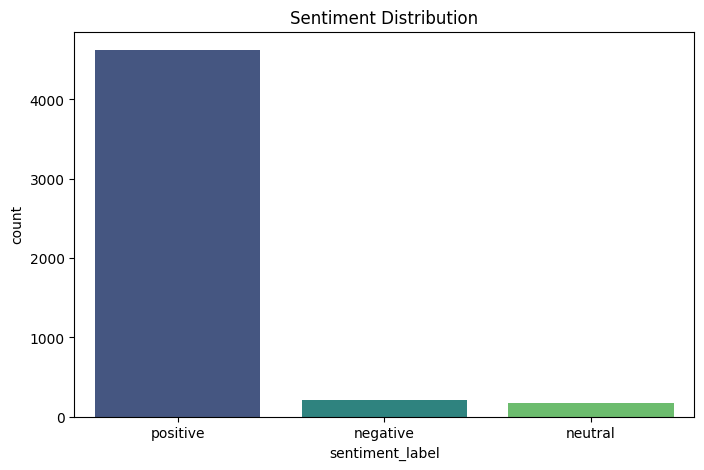

In [28]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment_label', palette='viridis')
plt.title("Sentiment Distribution")
plt.show()

In [29]:
# Generate Word Clouds for each sentiment
def plot_wordcloud(sentiment_label, title):
    text = ' '.join(df[df['sentiment_label'] == sentiment_label]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

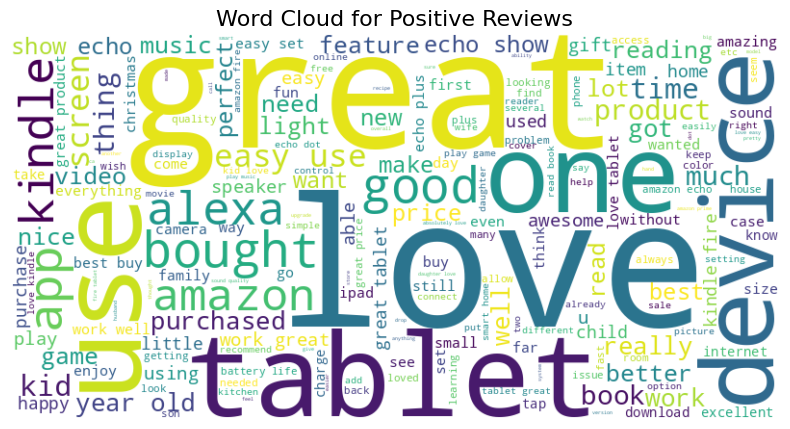

In [31]:
# Word Clouds for Positive, Negative, and Neutral Sentiments
plot_wordcloud('positive', 'Word Cloud for Positive Reviews')

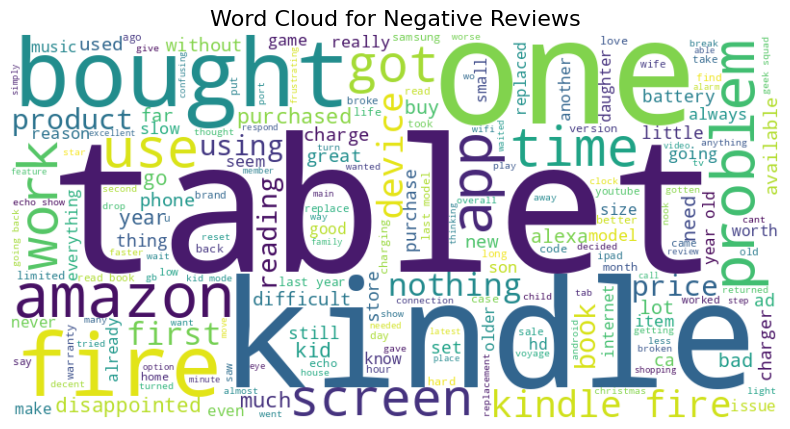

In [32]:
plot_wordcloud('negative', 'Word Cloud for Negative Reviews')

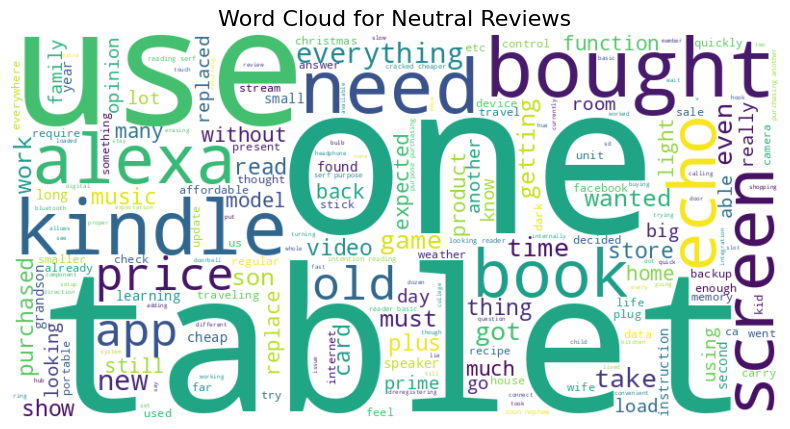

In [33]:
plot_wordcloud('neutral', 'Word Cloud for Neutral Reviews')

In [35]:
print(df.head(10))

     customerID              Purchasedate  \
0        llyyue 2017-03-03 16:56:05+00:00   
1        Charmi 2017-03-03 16:56:05+00:00   
2  johnnyjojojo 2017-03-03 16:56:05+00:00   
3       Kdperry 2017-03-03 16:56:05+00:00   
4   Johnnyblack 2017-03-03 16:56:05+00:00   
5    rmwarriors 2017-03-03 16:56:05+00:00   
6    LexieCrews 2017-03-03 16:56:05+00:00   
7         merry 2017-03-03 16:56:05+00:00   
8          STEF 2017-03-03 16:56:05+00:00   
9          AEBY 2017-03-03 16:56:05+00:00   

                                                name   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
5  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
6  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Am

In [34]:
# Save results
customer_behavior.to_csv("customer_clusters.csv", index=False)
df.to_csv("processed_reviews.csv", index=False)